In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import pickle
from scipy.stats import norm
import string
import datetime
from dateutil.relativedelta import relativedelta

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Авторизация гугл диска
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/

In [ ]:
# создаем датасет для проверки функций
np.random.seed(42)
n = 600
assert_data = pd.DataFrame(columns=['id', 'member_id', 'issue_d', 'target', 'test_flg', 'atr_int_1', 'atr_int_2', 'atr_int_3', 'atr_cat_1', 'atr_cat_2', 'atr_cat_3'])
assert_data['id'] = range(n)
assert_data['member_id'] = range(n)
assert_data['issue_d'] = [datetime.datetime.strftime(datetime.date(2000,1,1) + relativedelta(months=d),'%Y-%m-%d') for d in range(60)] * int(n/60)
assert_data['target'] = [np.random.randint(2) for i in range(n)]
assert_data['test_flg'] = [np.random.randint(2) for i in range(n)]
for i in range(1, 4):
    assert_data[f'atr_int_{i}'] = np.random.random(n)
    assert_data[f'atr_cat_{i}'] = np.random.random_integers(0, 25, n)

assert_tech_columns = ['id', 'member_id', 'issue_d', 'target']
assert_interrval_features = [f'atr_int_{i}' for i in range(1, 4)]
assert_category_features = [f'atr_cat_{i}' for i in range(1, 4)]
assert_features = assert_interrval_features + assert_category_features

assert_logreg = LogisticRegression(random_state=42)
assert_logreg.fit(assert_data[assert_data['test_flg']==0][assert_features], assert_data[assert_data['test_flg']==0]['target'])
assert_data['PD'] = assert_logreg.predict_proba(assert_data[assert_features])[:, -1]
# assert_data['PD'] = np.random.random(n)
assert_data['SCORE'] = np.round(assert_data[assert_features].values.dot(assert_logreg.coef_[0]) * 100)

assert_data['calib_flg'] = np.where(assert_data['issue_d']>'2001-12-01', 1, 0)

assert_data.head()

# Загрузка данных

In [ ]:
# Загрузка обученной модели
with open('./model_logreg_woe.pickle', 'rb') as f:
    model = pickle.load(f)
    
# Загрузка короткого списка атрибутов
with open('./attributes_logreg_woe.pickle', 'rb') as f:
    features = pickle.load(f)
    
# Загрузка выборки
data_backup = pd.read_csv('./data_grp_woe_pd_score.csv')
data_backup['issue_d'] = pd.to_datetime(data_backup['issue_d'])

In [ ]:
data = data_backup.copy()

# Task 1. Реализация алгоритмов калибровки

Выборку для калибровки можно формировать исходя из разных целей. 

В случае, если целью проведения калибровки является привести значения уровня дефолта к актуальному значению (Point-in-time - PIT), то в качестве выборки для калибровки следует использовать последние несколько месяцев выборки, которые характеризуют текущую экономическую ситуацию.

В случае, если целью проведения калибровки является привести значения уровня дефолта к историческому значению (Through-the-circle - TTC), то в качестве выборки для калибровки следует использовать те месяцы выборки, которые соответствуют последнему историческому экономическому циклу.

Выберете один из вариантов калибровки, объясните свой выбор, проставьте флаг выборки для калибровки.

In [ ]:
# Выборка для калибровки 
start_date = # YOUR CODE HERE
end_date = # YOUR CODE HERE
data['calib_flg'] = np.where(((data['issue_d'] > start_date) & (data['issue_d'] <= end_date)) , 1, 0)
print(f"Даты выборки для калибровки: с {data[data['calib_flg']==1]['issue_d'].min()} по {data[data['calib_flg']==1]['issue_d'].max()}")

Ниже реализована функция для сопоставление бина мастер-шкалы наблюдению в зависимости от вероятности дефолта данного наблюдения.

In [ ]:
# Функция для разбивки PD по обобщенной масетр-шкале
def f_master_gen(x):
    ans = np.where((0 <= x) & (x < 0.001), 'MA', 
                   np.where((0.001 <= x) & (x < 0.0027), 'MB', 
                            np.where((0.0027 <= x) & (x < 0.0075), 'MC', 
                                     np.where((0.0075 <= x) & (x < 0.0208), 'MD', 
                                              np.where((0.0208 <= x) & (x < 0.0577), 'ME', 
                                                       np.where((0.0577 <= x) & (x < 0.1601), 'MF', 
                                                                np.where((0.1601 <= x) & (x < 1), 'MG', 'MSD')
                                                               )
                                                      )
                                             )
                                    )
                           )
                  )
    
    return ans


# Функция для разбивки PD по детализированной масетр-шкале
def f_master_det(x):
    ans = np.where((0 <= x) & (x < 0.0005), 'MA1', 
                   np.where((0.0005 <= x) & (x < 0.0007), 'MA2', 
                            np.where((0.0007 <= x) & (x < 0.001), 'MA3', 
                                     np.where((0.001 <= x) & (x < 0.0014), 'MB1', 
                                              np.where((0.0014 <= x) & (x < 0.0019), 'MB2', 
                                                       np.where((0.0019 <= x) & (x < 0.0027), 'MB3', 
                                                                np.where((0.0027 <= x) & (x < 0.0032), 'MC1+', 
                                                                         np.where((0.0032 <= x) & (x < 0.0038), 'MC1-', 
                                                                                  np.where((0.0038 <= x) & (x < 0.0045), 'MC2+', 
                                                                                           np.where((0.0045 <= x) & (x < 0.0053), 'MC2-', 
                                                                                                    np.where((0.0053 <= x) & (x < 0.0063), 'MC3+', 
                                                                                                             np.where((0.0063 <= x) & (x < 0.0075), 'MC3-', 
                                                                                                                      np.where((0.0075 <= x) & (x < 0.0089), 'MD1+', 
                                                                                                                               np.where((0.0089 <= x) & (x < 0.0105), 'MD1-', 
                                                                                                                                        np.where((0.0105 <= x) & (x < 0.0125), 'MD2+', 
                                                                                                                                                 np.where((0.0125 <= x) & (x < 0.0148), 'MD2-', 
                                                                                                                                                          np.where((0.0148 <= x) & (x < 0.0176), 'MD3+', 
                                                                                                                                                                   np.where((0.0176 <= x) & (x < 0.0208), 'MD3-', 
                                                                                                                                                                            np.where((0.0208 <= x) & (x < 0.0247), 'ME1+', 
                                                                                                                                                                                     np.where((0.0247 <= x) & (x < 0.0293), 'ME1-', 
                                                                                                                                                                                              np.where((0.0293 <= x) & (x < 0.0347), 'ME2+', 
                                                                                                                                                                                                       np.where((0.0347 <= x) & (x < 0.0411), 'ME2-', 
                                                                                                                                                                                                                np.where((0.0411 <= x) & (x < 0.0487), 'ME3+', 
                                                                                                                                                                                                                         np.where((0.0487 <= x) & (x < 0.0577), 'ME3-', 
                                                                                                                                                                                                                                  np.where((0.0577 <= x) & (x < 0.0811), 'MF1', 
                                                                                                                                                                                                                                           np.where((0.0811 <= x) & (x < 0.114), 'MF2', 
                                                                                                                                                                                                                                                    np.where((0.114 <= x) & (x < 0.1601), 'MF3', 
                                                                                                                                                                                                                                                             np.where((0.1601 <= x) & (x < 0.225), 'MG1', 
                                                                                                                                                                                                                                                                      np.where((0.225 <= x) & (x < 0.3161), 'MG2', 
                                                                                                                                                                                                                                                                               np.where((0.3161 <= x) & (x < 1), 'MG3', 'MSD'))))))))))))))))))))))))))))))
    return ans

Сформируем новый столбец, содержащий наименование бина мастер-шкалы, определенного по вероятности дефолта нашей модели

In [ ]:
data['MS_gen_PD'] = f_master_gen(data['PD'])
data['MS_det_PD'] = f_master_det(data['PD'])

assert_data['MS_gen_PD'] = f_master_gen(assert_data['PD'])
assert_data['MS_det_PD'] = f_master_det(assert_data['PD'])

## Task 1-a. Калибровка Платта.

> Реализуйте функцию для обучения калибровки Платта (она же сигмоидальная калибровка) и добавление калиброванных значений к датасету.

> При реализации функции учтите следующее:
* Для реализации калибровки воспользуйтесь: CalibratedClassifierCV() 
* Настройте калибровку на выборке для калибровки без переобучения модели
* Имя столбца с калиброванным значением вероятности дефолта должно быть 'PD_calib_platt'

> Описание функции:
* На вход принимает:
1. model_ - обученная ранее модель
2. data_ - датасет со всеми полями
3. attributes - наименования атрибутов, на которых обучена модель
4. calib_flg_name - флаг принадлежности наблюдения к выборке для калибровки
5. target_name - имя целевого события
* Возвращает pandas.DataFrame с идентичными полями, что и исходный датафрейм + дополняет калиброванным значением 'PD_calib_platt'

In [ ]:
def calib_platt(model_, data_, attributes, calib_flg_name, target_name):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Проверяем реализацию функции
assert_data = calib_platt(model_ = assert_logreg, 
                          data_ = assert_data.copy(), 
                          attributes = assert_features, 
                          calib_flg_name = 'calib_flg',
                          target_name = 'target')

assert assert_data.shape == (600, 17)
assert 'PD_calib_platt' in assert_data.columns
assert round(assert_data['PD_calib_platt'].sum(), 5) == 330.5645

In [ ]:
%%time
# Применяем функцию к целевой таблице
data = calib_platt(model_ = model, 
                   data_ = data.copy(), 
                   attributes = [f'WOE_{col}' for col in features], 
                   calib_flg_name='calib_flg',
                   target_name='target')

## Task 1-b. Изотоническая калибровка

> Реализуйте функцию для обучения калибровки изотонической регрессией и добавление калиброванных значений к датасету.

> При реализации функции учтите следующее:
* Для реализации калибровки воспользуйтесь: CalibratedClassifierCV() 
* Настройте калибровку на выборке для калибровки без переобучения модели
* Имя столбца с калиброванным значением вероятности дефолта должно быть 'PD_calib_isoton'

> Описание функции:
* На вход принимает:
1. model_ - обученная ранее модель
2. data_ - датасет со всеми полями
3. attributes - наименования атрибутов, на которых обучена модель
4. calib_flg_name - флаг принадлежности наблюдения к выборке для калибровки
5. target_name - имя целевого события
* Возвращает pandas.DataFrame с идентичными полями, что и исходный датафрейм + дополняет калиброванным значением 'PD_calib_isoton'

In [ ]:
def calib_isoton(model_, data_, attributes, calib_flg_name, target_name):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Проверяем реализацию функции
assert_data = calib_isoton(model_ = assert_logreg, 
                           data_ = assert_data.copy(), 
                           attributes = assert_features, 
                           calib_flg_name = 'calib_flg',
                           target_name = 'target')

assert assert_data.shape == (600, 18)
assert 'PD_calib_isoton' in assert_data.columns
assert round(assert_data['PD_calib_isoton'].sum(), 5) == 330.48299

In [ ]:
%%time
# Применяем функцию к целевой таблице
data = calib_isoton(model_ = model, 
                    data_ = data.copy(), 
                    attributes = [f'WOE_{col}' for col in features], 
                    calib_flg_name='calib_flg',
                    target_name='target')

## Task 1-c. Калибровка Байеса

Алгоритм калибровки:
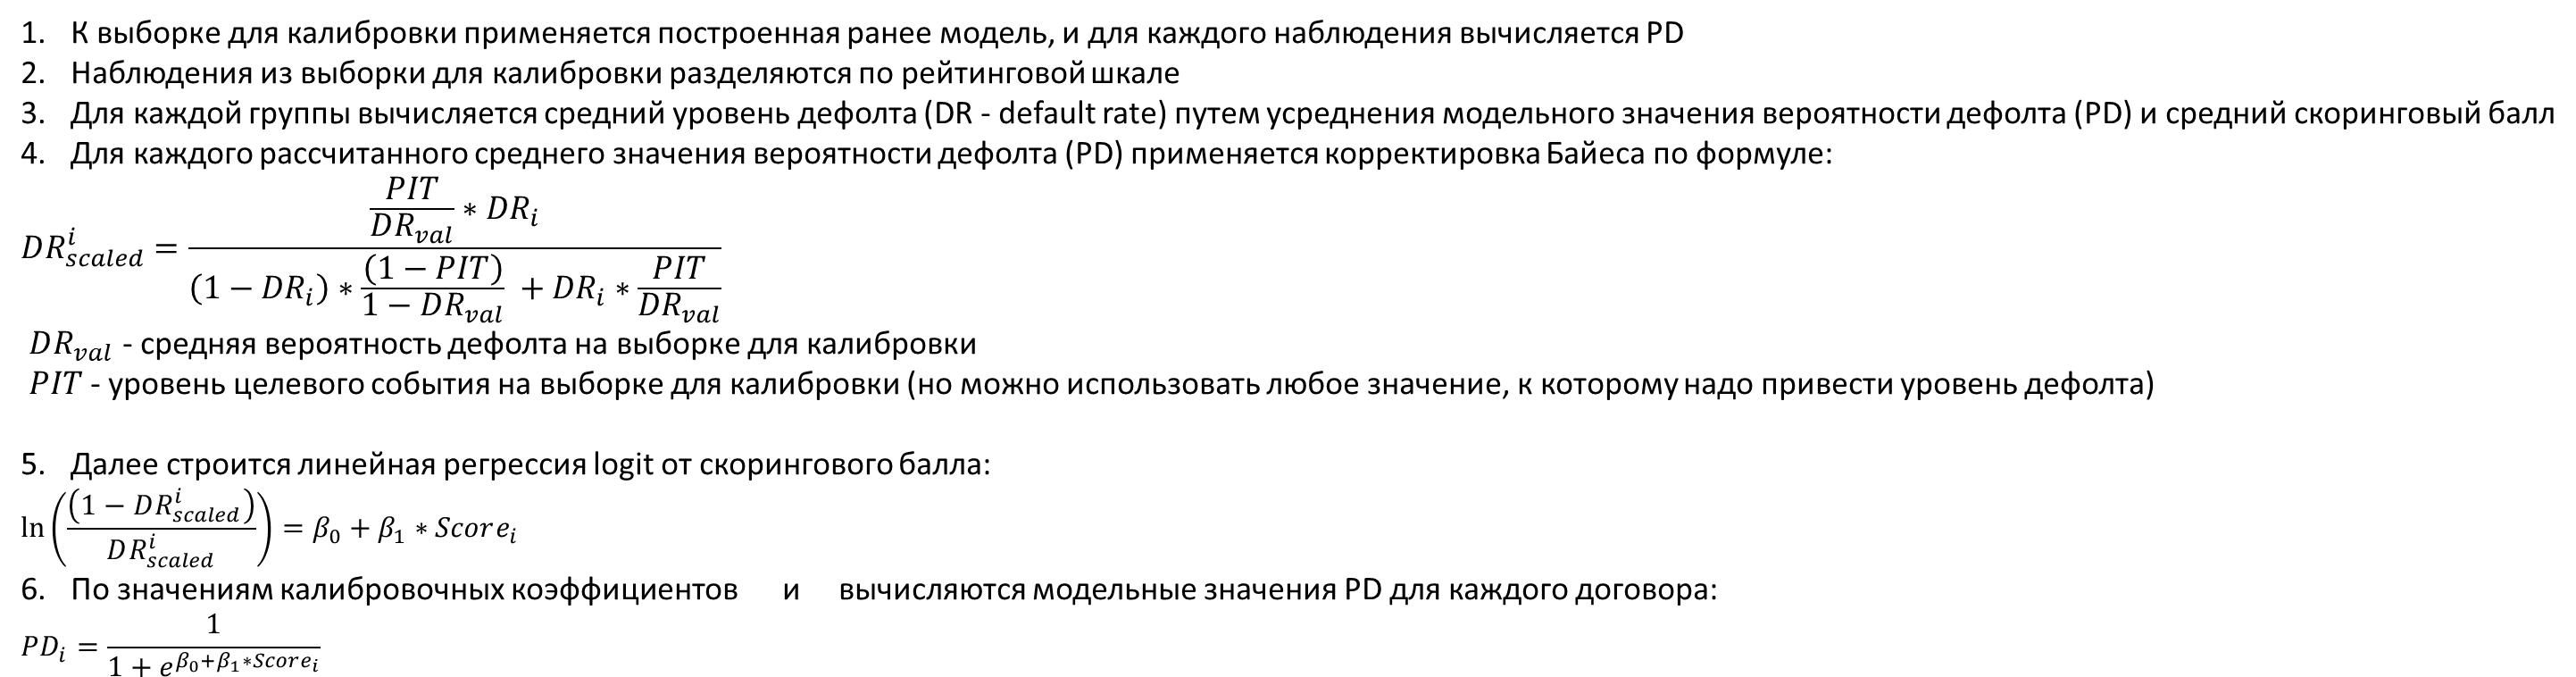

В пункте 6 PD_i считается для каждого наблюдения в отдельности, используя индивидуальные значения Score_i для каждого наблюдения

> Реализуйте функцию для обучения Байесовской калибровки и добавление калиброванных значений к датасету.

> При реализации функции учтите следующее:
* Имя столбца с калиброванным значением вероятности дефолта должно быть равно значению переменной column_name
* округлите до 5-го знака значения PIT, DR_val и коэффициенты регрессии

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми полями
2. master_scale_name - тип мастер-шкалы по которой строим калибровку
3. calib_flg_name - имя колонки с флагом принадлежности наблюдения к выборке для калибровки
4. test_flg_name - имя колонки с флагом принадлежности наблюдения к тестовой выборке
5. target_name - имя целевого событие
6. score_name - имя скорингового балла
7. column_name - имя нового столбца, куда будут записаны калиброванные значения вероятности дефолта
* Возвращает pandas.DataFrame с идентичными полями, что и исходный датафрейм + дополняет калиброванным значением column_name

In [ ]:
def bayes_calibration(data_, master_scale_name, calib_flg_name, test_flg_name, target_name, score_name, column_name):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Проверяем реализацию функции
# Калибровка по обобщенной мастер-шкале
assert_data = bayes_calibration(data_ = assert_data.copy(), 
                                master_scale_name='MS_gen_PD', 
                                calib_flg_name='calib_flg',
                                test_flg_name='test_flg',
                                target_name='target',
                                score_name='SCORE',
                                column_name='PD_calib_bayes_gen')

assert assert_data.shape == (600, 19)
assert 'PD_calib_bayes_gen' in assert_data.columns
assert round(assert_data['PD_calib_bayes_gen'].sum(), 5) == 333.33281

In [ ]:
# Проверяем реализацию функции
# Калибровка по детализированной мастер-шкале
assert_data = bayes_calibration(data_ = assert_data.copy(), 
                                master_scale_name='MS_det_PD', 
                                calib_flg_name='calib_flg',
                                test_flg_name='test_flg',
                                target_name='target',
                                score_name='SCORE',
                                column_name='PD_calib_bayes_det')

assert assert_data.shape == (600, 20)
assert 'PD_calib_bayes_det' in assert_data.columns
assert round(assert_data['PD_calib_bayes_det'].sum(), 5) == 328.33406

In [ ]:
%%time
# Применяем функцию к целевой таблице
# Калибровка по обобщенной мастер-шкале
data = bayes_calibration(data_ = data.copy(), 
                         master_scale_name = 'MS_gen_PD', 
                         calib_flg_name = 'calib_flg',
                         test_flg_name = 'test_flg',
                         target_name = 'target',
                         score_name = 'SCORE',
                         column_name = 'PD_calib_bayes_gen'
                         )

# Калибровка по обобщенной мастер-шкале
data = bayes_calibration(data_ = data.copy(), 
                         master_scale_name = 'MS_det_PD', 
                         calib_flg_name = 'calib_flg',
                         test_flg_name = 'test_flg',
                         target_name = 'target',
                         score_name = 'SCORE',
                         column_name = 'PD_calib_bayes_det'
                         )

# Task 2. Визуализация диаграмм надежности

> Реализуйте функцию отображения диаграмм надежности и вычисления Brier score

> При реализации функции учтите следующее:
* В качестве примера можете воспользоваться примером: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми полями
2. prob_names_list - имена колонок, содержащие вероятности дефолта, которые необходимо отобразить на диаграмме
* Отображает диаграмму надежности, аналогичную примеру
* Возвращает список Brier score для каждого целевого события




In [ ]:
# Функция для отрисовки диаграмм надежности
def plot_calibration_curve(data_, prob_names_list):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Проверяем реализацию функции
assert_brier_score_list = plot_calibration_curve(data_ = assert_data[assert_data['calib_flg']==1].copy(),
                                          prob_names_list = ['PD', 
                                                             'PD_calib_platt',
                                                             'PD_calib_isoton', 
                                                             'PD_calib_bayes_gen',
                                                             'PD_calib_bayes_det'
                                                             ]
                                          )
clear_output()
assert round(np.sum(assert_brier_score_list), 5) == 1.19124

In [ ]:
# Применяем функцию к целевой таблице
brier_score_list = plot_calibration_curve(data_=data[data['calib_flg']==1].copy(),
                                          prob_names_list = ['PD', 
                                                             'PD_calib_platt',
                                                             'PD_calib_isoton', 
                                                             'PD_calib_bayes_gen',
                                                             'PD_calib_bayes_det'
                                                             ]
                                          )

# Task 3. Визуализация распределения по мастер-шкале

> Реализуйте функцию для визуализации распределения вероятности дефолта по мастер-шкале.

> При реализации функции учтите следующее:
* не забудьте, что для каждого откалиброванного значения PD необходимо сделать свое распределение по мастер-шкале

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми полями
2. test_flg_name - флаг принадлежности наблюдения к тестовой выборке 
3. pd_name - имя столбца с вероятностью дефолта
4. target_name - имя целевого события
5. master_scale_type - тип мастер-шкалы (может быть 'generalized' - обобщенной и 'detailed' - детализированной)
* Возвращает список из двух pandas.DataFrame: первый элемент списка сформирован для train выборки, второй элемент списка сформирован для test выборки
* pandas.DataFrame содержат следующие столбцы:
1. MASTER_SCALE - названия бинов мастер-шкалы	
2. pd_name (параметр функции) - среднее значение столбца pd_name для соответствующего бина мастер-шкалы
3. target - среднее уровень дефолта наблюдений в соответствующем бине мастер-шкалы

In [ ]:
# Функция отображения распределений по мастер-шкале
def plot_master_distribution(data_, test_flg_name, pd_name, target_name, master_scale_type):
    # YPUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Проверяем реализацию функции
assert_df_list = []
pd_name_list = ['PD', 
                'PD_calib_platt',
                'PD_calib_isoton', 
                'PD_calib_bayes_gen',
                'PD_calib_bayes_det'
                ]
for pd_name in pd_name_list:
    for ms_type in ['generalized', 'detailed']:
        assert_df_list.append(plot_master_distribution(data_ = assert_data.copy(), 
                                                       test_flg_name = 'test_flg',
                                                       pd_name = pd_name,
                                                       target_name = 'target',
                                                       master_scale_type = ms_type
                                                       )
        )

res = 0
for i, ls in enumerate(assert_df_list):
    for j, d in enumerate(ls):
        res += assert_df_list[i][j]['target'].sum()
assert round(res, 5) == 13.32501

In [ ]:
# Применяем функцию к целевой таблице
pd_name_list = ['PD', 
                'PD_calib_platt',
                'PD_calib_isoton', 
                'PD_calib_bayes_gen',
                'PD_calib_bayes_det'
                ]
for pd_name in pd_name_list:
    for ms_type in ['generalized', 'detailed']:
        df_list = plot_master_distribution(data_ = data.copy(), 
                                            test_flg_name = 'test_flg',
                                            pd_name = pd_name,
                                            target_name = 'target',
                                            master_scale_type = ms_type
                                            )
        fig, ax = plt.subplots(1, 2, figsize=(18,6))
        df_name_list = ['TRAIN', 'TEST']
        for i, df in enumerate(df_list):
            
            ax[i].set_title(f'Распределение {pd_name} по {ms_type} мастер шкале \nна {df_name_list[i]} выборке')
            ax[i].set_xlabel('Бин мастер шкалы')
            ax[i].set_ylabel('Уровень дефолта')
            ax[i].tick_params(axis='x', rotation=90)

            ax[i].plot(df['MASTER_SCALE'], df['target'], label='target', linestyle ='-')
            ax[i].plot(df['MASTER_SCALE'], df[pd_name], label=pd_name, linestyle ='-')
            ax[i].legend()

        plt.show()

# Task 4. Биномиальный тест

Идея теста заключается в определении критического значения числа дефолтов или вероятности дефолта для каждого рейтингового класса и сравнения фактических значений с критическими.

В рамках данного теста выдвигаются следующие гипотезы:
H0 - все оценки PD, полученные при помощи модели, корректны
H1 - хотя бы одна оценка PD некорректна

Расчет доверительных интервалов:
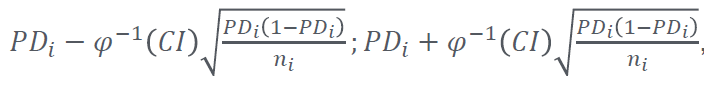

* 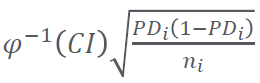 - критическое значение уровня дефолтов, аппроксимированное с помощью
нормального распределения
* 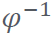 - обратная функция нормального распределения,
* 𝐶𝐼 - уровень доверия,
* 𝑃𝐷𝑖 - вероятность дефолта в i ом скоринговом классе.

> Реализуйте функцию для визуализации биномиального теста.

> При реализации функции учтите следующее:
* воспользуйтесь функцией norm.ppf(CI)

> Описание функции:
* На вход принимает:
1. data_ - датасет со всеми полями
2. pd_name - имя столбца с вероятностью дефолта
3. target_name - имя целевого события
4. master_scale_type - тип мастер-шкалы (может быть 'generalized' - обобщенной и 'detailed' - детализированной)
5. a_CI_for_binominal_test - доверительный интервал
* Возвращает pandas.DataFrame со следующими столбцами:
1. MASTER_SCALE - названия бинов мастер-шкалы	
2. pd_name (параметр функции) - среднее значение столбца pd_name для соответствующего бина мастер-шкалы
3. target - среднее уровень дефолта наблюдений в соответствующем бине мастер-шкалы
4. cnt - количество наблюдений в соответствующем бине мастер-шкалы
5. CI_LEFT - левая граница доверительного интервала для соответствующего бина мастер-шкалы
6. CI_RIGHT - правая граница доверительного интервала для соответствующего бина мастер-шкалы
7. conclusion - заключение о прохождении теста: 'тест пройден' или 'тест не пройден'

In [ ]:
def binomial_test(data_, pd_name, target_name, master_scale_type, a_CI_for_binominal_test):
    # YPUR CODE HERE
    raise NotImplementedError()

In [ ]:
# Проверяем реализацию функции
assert_df_list = []
pd_name_list = ['PD', 
                'PD_calib_platt',
                'PD_calib_isoton', 
                'PD_calib_bayes_gen',
                'PD_calib_bayes_det'
                ]
for pd_name in pd_name_list:
    for i, ms_type in enumerate(['generalized', 'detailed']):
        assert_df_list.append(binomial_test(data_ = assert_data[assert_data['calib_flg']==1].copy(), 
                              pd_name = pd_name,
                              target_name = 'target',
                              master_scale_type = ms_type,
                              a_CI_for_binominal_test = 0.99
                              ))
        
res_tar = 0
res_ci_left = 0
res_ci_right = 0
for i, d in enumerate(assert_df_list):
    res_tar += assert_df_list[i]['target'].sum()
    res_ci_left += assert_df_list[i]['CI_LEFT'].sum()
    res_ci_right += assert_df_list[i]['CI_RIGHT'].sum()
assert round(res_tar, 5) == 6.47692
assert round(res_ci_left, 5) == 4.25204
assert round(res_ci_right, 5) == 8.54361

In [ ]:
# Применяем функцию к целевой таблице
pd_name_list = ['PD', 
                'PD_calib_platt',
                'PD_calib_isoton', 
                'PD_calib_bayes_gen',
                'PD_calib_bayes_det'
                ]
for pd_name in pd_name_list:
    fig, ax = plt.subplots(1, 2, figsize=(18,6))
    for i, ms_type in enumerate(['generalized', 'detailed']):
        df = binomial_test(data_ = data[data['calib_flg']==1].copy(), 
                           pd_name = pd_name,
                           target_name = 'target',
                           master_scale_type = ms_type,
                           a_CI_for_binominal_test = 0.99
                           )
        
        # визуализация
        ax[i].set_title(f'Биномиальный тест для {pd_name} по {ms_type} мастер шкале')
        ax[i].set_xlabel('Мастер-шкала')
        ax[i].set_ylabel('Вероятность дефолта')
        ax[i].tick_params(axis='x', rotation=90)
        
        ax[i].plot(df['MASTER_SCALE'], df['CI_LEFT'], label='ДИ левая граница')
        ax[i].plot(df['MASTER_SCALE'], df['CI_RIGHT'], label='ДИ правая граница')
        ax[i].scatter(df[df['conclusion']=='тест пройден']['MASTER_SCALE'], 
                df[df['conclusion']=='тест пройден']['target'], 
                label='Фактический уровень дефолта внутри ДИ',
                color = 'green'
                )
        ax[i].scatter(df[df['conclusion']=='тест не пройден']['MASTER_SCALE'], 
                df[df['conclusion']=='тест не пройден']['target'], 
                label='Фактический уровень дефолта вне ДИ',
                color = 'red'
                )
        ax[i].legend()

    plt.show()

# Сохранение результатов

Выберете способ предпочитаемой калибровки, объясните свой выбор.

Сохраните выбранное значение калиброванного значения PD в таблицу с наименованием поля "PD_calib".

Также проставим бакет по мастер-шкале в зависимости от значения PD_calib.

In [ ]:
data['PD_calib'] = data['PD_calib_isoton']
data['MS_gen_PD_calib'] = f_master_gen(data['PD_calib'])
data['MS_det_PD_calib'] = f_master_det(data['PD_calib'])

In [ ]:
data.to_csv('./data_grp_woe_pd_score_calib.csv', index=False)